<a href="https://colab.research.google.com/github/drish08/Fraud-Detection-by-Autoencoder/blob/main/autoencoder_with_RNN_and_SoftMax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/creditcard_2023.csv')
data.head()
data.shape

(568630, 31)

# **5 FEATURES with RNN Classifier**

Epoch 1/5, Loss: 0.4223
Epoch 2/5, Loss: 0.4964
Epoch 3/5, Loss: 0.3630
Epoch 4/5, Loss: 0.2162
Epoch 5/5, Loss: 0.2702
Shape of Encoded Features: (113726, 5)
Epoch 1/10, Loss: 0.0139
Epoch 2/10, Loss: 0.0319
Epoch 3/10, Loss: 0.0694
Epoch 4/10, Loss: 0.0878
Epoch 5/10, Loss: 0.0699
Epoch 6/10, Loss: 0.1293
Epoch 7/10, Loss: 0.3919
Epoch 8/10, Loss: 0.0172
Epoch 9/10, Loss: 0.1548
Epoch 10/10, Loss: 0.0567
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     11311
           1       0.98      0.94      0.96     11435

    accuracy                           0.96     22746
   macro avg       0.96      0.96      0.96     22746
weighted avg       0.96      0.96      0.96     22746



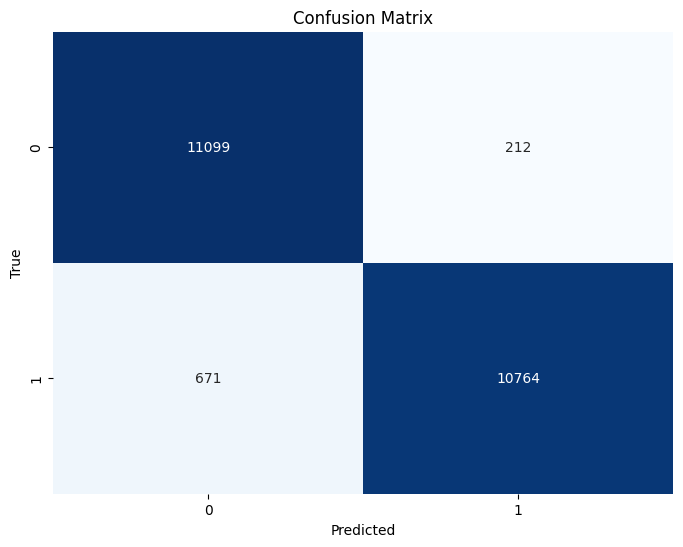

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Separating features and labels
X = data.iloc[:, :-1].values  #last column is the target variable
y = data.iloc[:, -1].values

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)

# Create DataLoader instances
batch_size = 64
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X_train.shape[1], 16),
            nn.PReLU(16),
            nn.BatchNorm1d(16),
            nn.Linear(16, 5),
            nn.PReLU(5),
            nn.BatchNorm1d(5)
        )
        self.decoder = nn.Sequential(
            nn.Linear(5, 16),
            nn.PReLU(16),
            nn.BatchNorm1d(16),
            nn.Linear(16, X_train.shape[1])
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Setting device
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# Creating the model and moving it to the device
autoencoder = Autoencoder().to(device)

# Defining optimizer
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=0.005)

# Training the autoencoder
num_epochs = 5

for epoch in range(num_epochs):
    for batch_data, in train_loader:
        batch_data = batch_data.to(device)

        autoencoder.zero_grad()
        reconstructions = autoencoder(batch_data)
        loss = nn.functional.mse_loss(reconstructions, batch_data)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

# Extracting encoded features from the test set
encoded_features = []
with torch.no_grad():
    for batch_data, in test_loader:
        batch_data = batch_data.to(device)
        encoded_batch = autoencoder.encoder(batch_data)
        encoded_features.append(encoded_batch.cpu().numpy())

# Concatenating the encoded features
encoded_features = np.concatenate(encoded_features, axis=0)

# Printing the shape of the encoded features
print("Shape of Encoded Features:", encoded_features.shape)

# Split the encoded features into training and testing sets for classification
X_classify_train, X_classify_test, y_classify_train, y_classify_test = train_test_split(encoded_features, y_test, test_size=0.2, random_state=42)

# Converting encoded features and labels to PyTorch tensor
X_classify_train_tensor = torch.Tensor(X_classify_train)
y_classify_train_tensor = torch.Tensor(y_classify_train).long()

# Create DataLoader instance for the encoded features and labels
classify_train_dataset = TensorDataset(X_classify_train_tensor, y_classify_train_tensor)
classify_train_loader = DataLoader(classify_train_dataset, batch_size=batch_size, shuffle=True)

import torch.nn.functional as F

# Convert encoded features and labels to PyTorch tensor
X_classify_train_tensor = torch.Tensor(X_classify_train)
y_classify_train_tensor = torch.Tensor(y_classify_train).long()

# Create DataLoader instance for the encoded features and labels
classify_train_dataset = TensorDataset(X_classify_train_tensor, y_classify_train_tensor)
classify_train_loader = DataLoader(classify_train_dataset, batch_size=batch_size, shuffle=True)

# Defining the RNN classifier
class RNNClassifier(nn.Module):
    def __init__(self, input_size, rnn_hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=rnn_hidden_size, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Using the last output of the sequence
        return out

# Parameters for RNN classifier
rnn_hidden_size_classify = 64
num_classes_classify = 2  #binary classification

# Creating the RNN classifier model and moving to the device
rnn_model_classify = RNNClassifier(
    input_size=encoded_features.shape[1], rnn_hidden_size=rnn_hidden_size_classify, num_classes=num_classes_classify
).to(device)

# Defining the optimizer and criterion for classification
optimizer_classify = torch.optim.Adam(params=rnn_model_classify.parameters(), lr=0.001)
criterion_classify = nn.CrossEntropyLoss()

# Training the RNN classifier
num_epochs_classify = 10

for epoch in range(num_epochs_classify):
    for batch_data_classify, batch_labels_classify in classify_train_loader:
        optimizer_classify.zero_grad()
        outputs_classify = rnn_model_classify(batch_data_classify.unsqueeze(1))  # unsqueeze for sequence dimension
        loss_classify = criterion_classify(outputs_classify, batch_labels_classify.long())
        loss_classify.backward()
        optimizer_classify.step()

    print(f'Epoch {epoch + 1}/{num_epochs_classify}, Loss: {loss_classify.item():.4f}')

# Evaluating the RNN classifier on the test set
X_classify_test_tensor = torch.Tensor(X_classify_test)
y_classify_test_tensor = torch.Tensor(y_classify_test).long()

with torch.no_grad():
    rnn_model_classify.eval()
    outputs_test_classify = rnn_model_classify(X_classify_test_tensor.unsqueeze(1))
    predictions_classify = torch.argmax(F.softmax(outputs_test_classify, dim=1), dim=1)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_classify_test, predictions_classify.cpu().numpy()))

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_classify_test, predictions_classify.cpu().numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# **5 FEATURE with SoftMax Classifier**

Shape of Encoded Features: (113726, 5)
Softmax Classifier - Epoch 1/5, Loss: 0.1607
Softmax Classifier - Epoch 2/5, Loss: 0.0797
Softmax Classifier - Epoch 3/5, Loss: 0.0621
Softmax Classifier - Epoch 4/5, Loss: 0.0823
Softmax Classifier - Epoch 5/5, Loss: 0.1448
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     11311
           1       0.97      0.94      0.95     11435

    accuracy                           0.95     22746
   macro avg       0.95      0.95      0.95     22746
weighted avg       0.95      0.95      0.95     22746



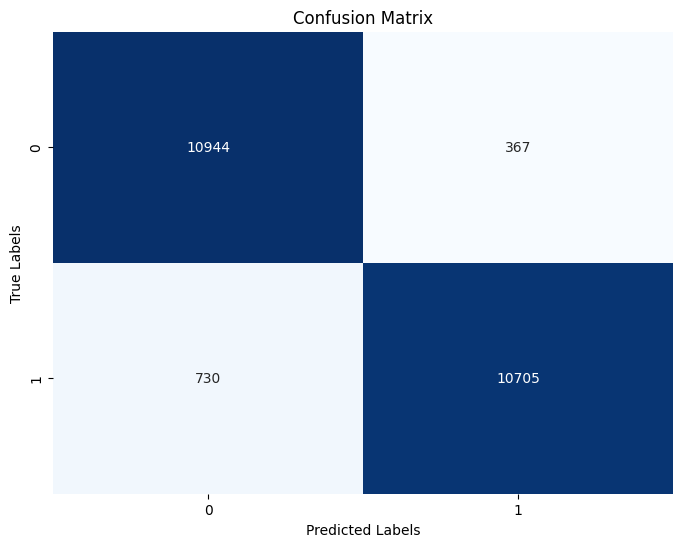

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#'encoded_dim' is the number of features after encoding
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# Print the shape of the encoded features
print("Shape of Encoded Features:", encoded_features.shape)

# Define the number of features after encoding
encoded_dim = encoded_features.shape[1]

# Set up the softmax classifier model
num_classes_softmax = 2  # Assuming binary classification
softmax_model = SoftmaxClassifier(input_size=encoded_dim, num_classes=num_classes_softmax).to(device)

# Define loss function and optimizer
criterion_softmax = nn.CrossEntropyLoss()
optimizer_softmax = torch.optim.Adam(params=softmax_model.parameters(), lr=0.001)

# Training the softmax classifier
num_epochs_softmax = 5

for epoch in range(num_epochs_softmax):
    for batch_data_softmax, batch_labels_softmax in classify_train_loader:
        batch_data_softmax, batch_labels_softmax = batch_data_softmax.to(device), batch_labels_softmax.to(device)

        optimizer_softmax.zero_grad()
        outputs_softmax = softmax_model(batch_data_softmax)
        loss_softmax = criterion_softmax(outputs_softmax, batch_labels_softmax.long())
        loss_softmax.backward()
        optimizer_softmax.step()

    print(f'Softmax Classifier - Epoch {epoch + 1}/{num_epochs_softmax}, Loss: {loss_softmax.item():.4f}')

# Evaluate the softmax classifier on the test set
softmax_model.eval()
with torch.no_grad():
    test_data_tensor = torch.Tensor(X_classify_test).to(device)
    predicted_labels = softmax_model(test_data_tensor)
    predicted_labels = torch.argmax(predicted_labels, dim=1).cpu().numpy()

# Print the classification report
print("Classification Report:")
print(classification_report(y_classify_test, predicted_labels))

# Plot the confusion matrix
cm_5_sm = confusion_matrix(y_classify_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_5_sm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **10 FEATURES with RNN Classifier**

Epoch 1/10, Loss: 0.2009
Epoch 2/10, Loss: 0.1759
Epoch 3/10, Loss: 0.1624
Epoch 4/10, Loss: 0.1497
Epoch 5/10, Loss: 0.1625
Epoch 6/10, Loss: 0.2000
Epoch 7/10, Loss: 0.1926
Epoch 8/10, Loss: 0.1607
Epoch 9/10, Loss: 0.1896
Epoch 10/10, Loss: 0.1654
Shape of Encoded Features of 10 features: (113726, 10)
Reconstruction Error (MSE) for the batch: 0.1799
Epoch 1/10, Loss: 0.1358
Epoch 2/10, Loss: 0.1497
Epoch 3/10, Loss: 0.1984
Epoch 4/10, Loss: 0.0717
Epoch 5/10, Loss: 0.1724
Epoch 6/10, Loss: 0.0215
Epoch 7/10, Loss: 0.0069
Epoch 8/10, Loss: 0.0790
Epoch 9/10, Loss: 0.0241
Epoch 10/10, Loss: 0.0616
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     11311
           1       0.99      0.98      0.98     11435

    accuracy                           0.98     22746
   macro avg       0.98      0.98      0.98     22746
weighted avg       0.98      0.98      0.98     22746



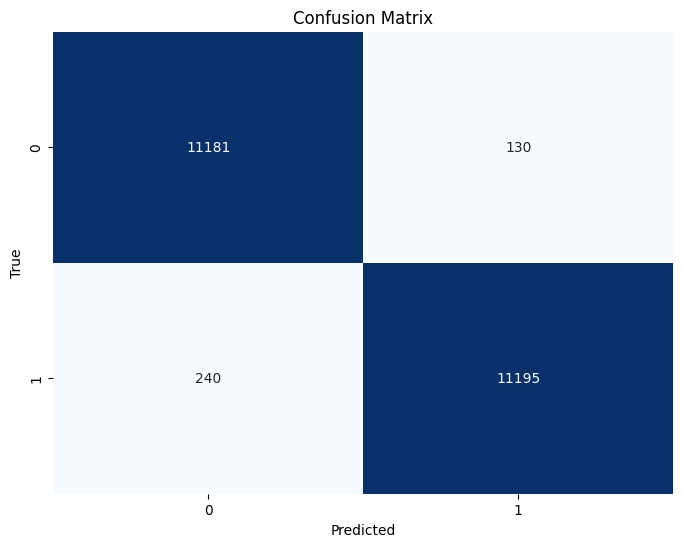

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Separating features and labels
X = data.iloc[:, :-1].values  #the last column is the target variable
y = data.iloc[:, -1].values

# Normalizing the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train_tensor_10 = torch.Tensor(X_train_10)
X_test_tensor_10 = torch.Tensor(X_test_10)

# Creating DataLoader instances
batch_size = 64
train_dataset = TensorDataset(X_train_tensor_10)
test_dataset = TensorDataset(X_test_tensor_10)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder definition
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X_train.shape[1], 16),
            nn.PReLU(16),
            nn.BatchNorm1d(16),
            nn.Linear(16, 10),  # Updated to 10 features
            nn.PReLU(10),
            nn.BatchNorm1d(10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 16),
            nn.PReLU(16),
            nn.BatchNorm1d(16),
            nn.Linear(16, X_train.shape[1])
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Setting device (GPU if available)
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# Creating the model and moving it to the device
autoencoder = Autoencoder().to(device)

# Defining optimizer
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=0.005)

# Training the autoencoder
num_epochs = 10

for epoch in range(num_epochs):
    for batch_data_10, in train_loader:
        batch_data_10 = batch_data_10.to(device)

        autoencoder.zero_grad()
        reconstructions = autoencoder(batch_data_10)
        loss = nn.functional.mse_loss(reconstructions, batch_data_10)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

# Extracting encoded features from the test set
encoded_features_10 = []
with torch.no_grad():
    for batch_data_10, in test_loader:
        batch_data_10 = batch_data_10.to(device)
        encoded_batch = autoencoder.encoder(batch_data_10)
        encoded_features_10.append(encoded_batch.cpu().numpy())

# Concatenating the encoded features
encoded_features_10 = np.concatenate(encoded_features_10, axis=0)

# Print the shape of the encoded features
print("Shape of Encoded Features of 10 features:", encoded_features_10.shape)

# `batch_data` is a batch of input data
with torch.no_grad():
    autoencoder.eval()
    reconstructions = autoencoder(batch_data_10.to(device))
    mse_loss = nn.functional.mse_loss(reconstructions, batch_data_10.to(device))
    print(f"Reconstruction Error (MSE) for the batch: {mse_loss.item():.4f}")

# Split the encoded features into training and testing sets for classification
X_classify_train_10, X_classify_test_10, y_classify_train_10, y_classify_test_10 = train_test_split(encoded_features_10, y_test, test_size=0.2, random_state=42)

import torch.nn.functional as F

# Converting encoded features and labels to PyTorch tensor
X_classify_train_tensor_10 = torch.Tensor(X_classify_train_10)
y_classify_train_tensor_10 = torch.Tensor(y_classify_train_10).long()

# Creating DataLoader instance for the encoded features and labels
classify_train_dataset = TensorDataset(X_classify_train_tensor_10, y_classify_train_tensor_10)
classify_train_loader = DataLoader(classify_train_dataset, batch_size=batch_size, shuffle=True)

# Defining the RNN classifier
class RNNClassifier(nn.Module):
    def __init__(self, input_size, rnn_hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=rnn_hidden_size, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Using the last output of the sequence
        return out

# Parameters for RNN classifier
rnn_hidden_size_classify = 64
num_classes_classify = 2  # binary classification

# Creating the RNN classifier model  and moving to the device
rnn_model_classify = RNNClassifier(input_size=10, rnn_hidden_size=rnn_hidden_size_classify, num_classes=num_classes_classify).to(device)

# Defining the optimizer and criterion for classification
optimizer_classify = torch.optim.Adam(params=rnn_model_classify.parameters(), lr=0.001)
criterion_classify = nn.CrossEntropyLoss()

# Training the RNN classifier
num_epochs_classify = 10

for epoch in range(num_epochs_classify):
    for batch_data_classify, batch_labels_classify in classify_train_loader:
        optimizer_classify.zero_grad()
        outputs_classify = rnn_model_classify(batch_data_classify.unsqueeze(1))  # unsqueeze for sequence dimension
        loss_classify = criterion_classify(outputs_classify, batch_labels_classify.long())
        loss_classify.backward()
        optimizer_classify.step()

    print(f'Epoch {epoch + 1}/{num_epochs_classify}, Loss: {loss_classify.item():.4f}')

# Evaluating the RNN classifier on the test set
X_classify_test_tensor_10 = torch.Tensor(X_classify_test_10)
y_classify_test_tensor_10 = torch.Tensor(y_classify_test_10).long()

with torch.no_grad():
    rnn_model_classify.eval()
    outputs_test_classify_10 = rnn_model_classify(X_classify_test_tensor_10.unsqueeze(1))
    predictions_classify_10 = torch.argmax(F.softmax(outputs_test_classify_10, dim=1), dim=1)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_classify_test_10, predictions_classify_10.cpu().numpy()))

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# confusion matrix calculation
cm_10 = confusion_matrix(y_classify_test_10, predictions_classify_10.cpu().numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_10, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



# **10 FEATURES with SoftMax Classifier**

Shape of Encoded Features for 10 features: (113726, 10)
Softmax Classifier - Epoch 1/5, Loss: 0.0816
Softmax Classifier - Epoch 2/5, Loss: 0.1372
Softmax Classifier - Epoch 3/5, Loss: 0.0723
Softmax Classifier - Epoch 4/5, Loss: 0.0191
Softmax Classifier - Epoch 5/5, Loss: 0.0908
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11311
           1       0.98      0.96      0.97     11435

    accuracy                           0.97     22746
   macro avg       0.97      0.97      0.97     22746
weighted avg       0.97      0.97      0.97     22746



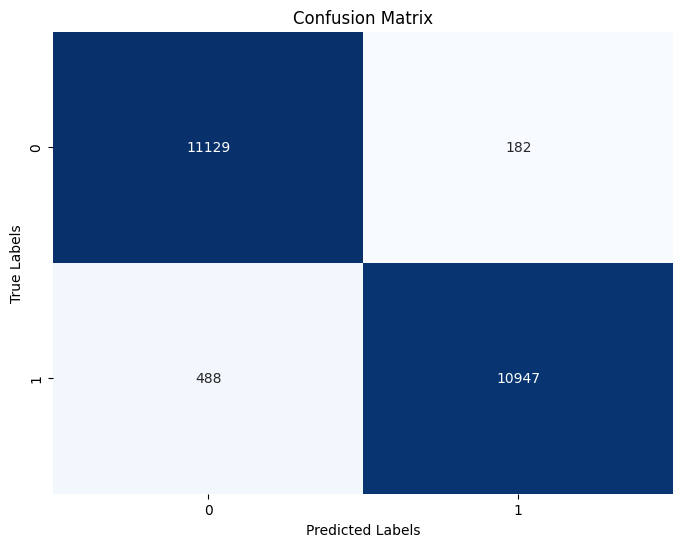

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#encoded features with 10 dimensions
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# Print the shape of the encoded features
print("Shape of Encoded Features for 10 features:", encoded_features_10.shape)

# Defining the number of features after encoding
encoded_dim_10 = encoded_features_10.shape[1]

# Setting up the softmax classifier model
num_classes_softmax_10 = 2  #binary classification
softmax_model_10 = SoftmaxClassifier(input_size=encoded_dim_10, num_classes=num_classes_softmax_10).to(device)

# Defining loss function and optimizer
criterion_softmax_10 = nn.CrossEntropyLoss()
optimizer_softmax_10 = torch.optim.Adam(params=softmax_model_10.parameters(), lr=0.001)

# Training the softmax classifier
num_epochs_softmax_10 = 5

for epoch in range(num_epochs_softmax_10):
    for batch_data_softmax_10, batch_labels_softmax_10 in classify_train_loader:
        batch_data_softmax_10, batch_labels_softmax_10 = batch_data_softmax_10.to(device), batch_labels_softmax_10.to(device)

        optimizer_softmax_10.zero_grad()
        outputs_softmax_10 = softmax_model_10(batch_data_softmax_10)
        loss_softmax_10 = criterion_softmax_10(outputs_softmax_10, batch_labels_softmax_10.long())
        loss_softmax_10.backward()
        optimizer_softmax_10.step()

    print(f'Softmax Classifier - Epoch {epoch + 1}/{num_epochs_softmax_10}, Loss: {loss_softmax_10.item():.4f}')

# Evaluating the softmax classifier on the test set
softmax_model_10.eval()
with torch.no_grad():
    test_data_tensor_10 = torch.Tensor(X_classify_test_10).to(device)
    predicted_labels_10 = softmax_model_10(test_data_tensor_10)
    predicted_labels_10 = torch.argmax(predicted_labels_10, dim=1).cpu().numpy()

# Printing the classification report
print("Classification Report:")
print(classification_report(y_classify_test_10, predicted_labels_10))

# Plotting the confusion matrix
cm_10sm = confusion_matrix(y_classify_test_10, predicted_labels_10)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_10sm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# **20 Features with RNN Classifier**

Epoch 1/5, Loss: 0.1893
Epoch 2/5, Loss: 0.1188
Epoch 3/5, Loss: 0.1751
Epoch 4/5, Loss: 0.1104
Epoch 5/5, Loss: 0.1117
Shape of Encoded Features (20): (113726, 20)
Reconstruction Error (MSE) for the batch (20 features): 0.1387
Epoch 1/10, Loss: 0.0120
Epoch 2/10, Loss: 0.0340
Epoch 3/10, Loss: 0.0871
Epoch 4/10, Loss: 0.0084
Epoch 5/10, Loss: 0.0173
Epoch 6/10, Loss: 0.0191
Epoch 7/10, Loss: 0.0326
Epoch 8/10, Loss: 0.0030
Epoch 9/10, Loss: 0.0285
Epoch 10/10, Loss: 0.0010
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     11311
           1       0.99      0.99      0.99     11435

    accuracy                           0.99     22746
   macro avg       0.99      0.99      0.99     22746
weighted avg       0.99      0.99      0.99     22746



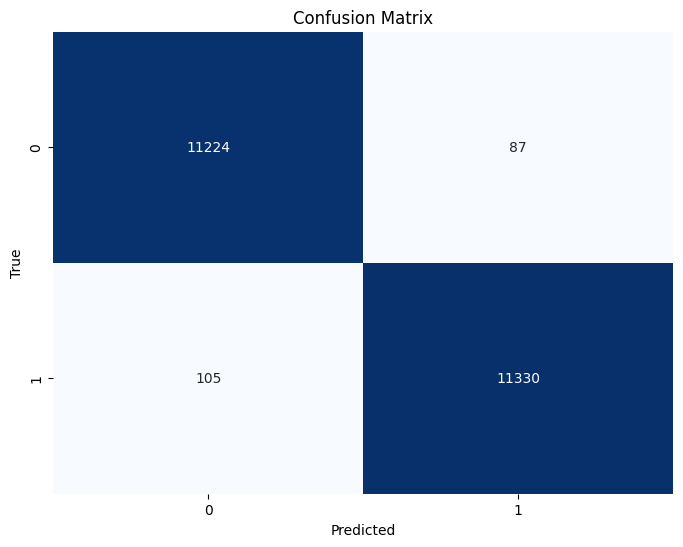

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Separate features and labels
X = data.iloc[:, :-1].values  #the last column is the target variable
y = data.iloc[:, -1].values

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor_20 = torch.Tensor(X_train)
X_test_tensor_20 = torch.Tensor(X_test)

# Create DataLoader instances
batch_size = 64
train_dataset = TensorDataset(X_train_tensor_20)
test_dataset = TensorDataset(X_test_tensor_20)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder definition
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X_train.shape[1], 16),
            nn.PReLU(16),
            nn.BatchNorm1d(16),
            nn.Linear(16, 20),  # for to 20 features
            nn.PReLU(20),
            nn.BatchNorm1d(20)
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 16),
            nn.PReLU(16),
            nn.BatchNorm1d(16),
            nn.Linear(16, X_train.shape[1])
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Setting device
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# Creating the model and moving it to the device
autoencoder = Autoencoder().to(device)

# Defining optimizer
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=0.005)

# Training the autoencoder
num_epochs = 5

for epoch in range(num_epochs):
    for batch_data, in train_loader:
        batch_data = batch_data.to(device)

        autoencoder.zero_grad()
        reconstructions = autoencoder(batch_data)
        loss = nn.functional.mse_loss(reconstructions, batch_data)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

# Extracting encoded features from the test set
encoded_features_20 = []
with torch.no_grad():
    for batch_data, in test_loader:
        batch_data = batch_data.to(device)
        encoded_batch = autoencoder.encoder(batch_data)
        encoded_features_20.append(encoded_batch.cpu().numpy())

# Concatenating the encoded features
encoded_features_20 = np.concatenate(encoded_features_20, axis=0)

# Print the shape of the encoded features
print("Shape of Encoded Features (20):", encoded_features_20.shape)

# Split the encoded features into training and testing sets for classification
X_classify_train_20, X_classify_test_20, y_classify_train_20, y_classify_test_20 = train_test_split(encoded_features_20, y_test, test_size=0.2, random_state=42
)

# Convert encoded features and labels to PyTorch tensor
X_classify_train_tensor_20 = torch.Tensor(X_classify_train_20)
y_classify_train_tensor_20 = torch.Tensor(y_classify_train_20).long()

# Create DataLoader instance for the encoded features and labels
classify_train_dataset_20 = TensorDataset(X_classify_train_tensor_20, y_classify_train_tensor_20)
classify_train_loader_20 = DataLoader(classify_train_dataset_20, batch_size=batch_size, shuffle=True)

# Assuming `batch_data` is a batch of input data
with torch.no_grad():
    autoencoder.eval()
    reconstructions_20 = autoencoder(batch_data.to(device))
    mse_loss_20 = nn.functional.mse_loss(reconstructions_20, batch_data.to(device))
    print(f"Reconstruction Error (MSE) for the batch (20 features): {mse_loss_20.item():.4f}")

# Define the RNN classifier for 20 features
class RNNClassifier(nn.Module):
    def __init__(self, input_size, rnn_hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=rnn_hidden_size, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Using the last output of the sequence
        return out

# Parameters for RNN classifier for 20 features
rnn_hidden_size_classify_20 = 64
num_classes_classify_20 = 2  # binary classification

# Creating and moving the RNN classifier model to the device for 20 features
rnn_model_classify_20 = RNNClassifier(input_size=20, rnn_hidden_size=rnn_hidden_size_classify_20, num_classes=num_classes_classify_20).to(device)

# Defining the optimizer and criterion for classification for 20 features
optimizer_classify_20 = torch.optim.Adam(params=rnn_model_classify_20.parameters(), lr=0.001)
criterion_classify_20 = nn.CrossEntropyLoss()

# Training the RNN classifier for 20 features
num_epochs_classify_20 = 10

for epoch in range(num_epochs_classify_20):
    for batch_data_classify, batch_labels_classify in classify_train_loader_20:
        optimizer_classify_20.zero_grad()
        outputs_classify_20 = rnn_model_classify_20(batch_data_classify.unsqueeze(1))  #unsqueeze for sequence dimension
        loss_classify_20 = criterion_classify_20(outputs_classify_20, batch_labels_classify.long())
        loss_classify_20.backward()
        optimizer_classify_20.step()

    print(f'Epoch {epoch + 1}/{num_epochs_classify_20}, Loss: {loss_classify_20.item():.4f}')

# Evaluate the RNN classifier on the test set
X_classify_test_tensor_20 = torch.Tensor(X_classify_test_20)

# Adding an additional dimension for the sequence length
X_classify_test_tensor_20 = X_classify_test_tensor_20.unsqueeze(1)
y_classify_test_tensor_20 = torch.Tensor(y_classify_test_20).long()

with torch.no_grad():
    rnn_model_classify_20.eval()
    outputs_test_classify_20 = rnn_model_classify_20(X_classify_test_tensor_20)
    predictions_classify = torch.argmax(F.softmax(outputs_test_classify_20, dim=1), dim=1)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_classify_test, predictions_classify.cpu().numpy()))

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_20rnn = confusion_matrix(y_classify_test, predictions_classify.cpu().numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_20rnn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# **20 Features with SoftMax Classifier**

Shape of Encoded Features (20): (113726, 20)
Softmax Classifier - Epoch 1/10, Loss: 0.0587
Softmax Classifier - Epoch 2/10, Loss: 0.0462
Softmax Classifier - Epoch 3/10, Loss: 0.0406
Softmax Classifier - Epoch 4/10, Loss: 0.0359
Softmax Classifier - Epoch 5/10, Loss: 0.0463
Softmax Classifier - Epoch 6/10, Loss: 0.0131
Softmax Classifier - Epoch 7/10, Loss: 0.0506
Softmax Classifier - Epoch 8/10, Loss: 0.0357
Softmax Classifier - Epoch 9/10, Loss: 0.0268
Softmax Classifier - Epoch 10/10, Loss: 0.0620
Classification Report (20 dimensions):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11311
           1       0.99      0.98      0.98     11435

    accuracy                           0.98     22746
   macro avg       0.98      0.98      0.98     22746
weighted avg       0.98      0.98      0.98     22746



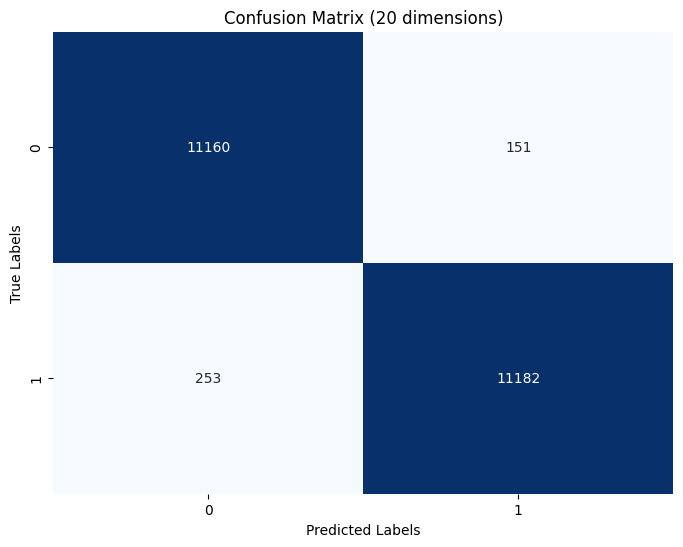

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# encoded features with 20 dimensions
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# Print the shape of the encoded features
print("Shape of Encoded Features (20):", encoded_features_20.shape)

# Define the number of features after encoding for 20 dimensions
encoded_dim_20 = encoded_features_20.shape[1]

# Set up the softmax classifier model for 20 dimensions
num_classes_softmax_20 = 2  # binary classification
softmax_model_20 = SoftmaxClassifier(input_size=encoded_dim_20, num_classes=num_classes_softmax_20).to(device)

# Define loss function and optimizer for 20 dimensions
criterion_softmax_20 = nn.CrossEntropyLoss()
optimizer_softmax_20 = torch.optim.Adam(params=softmax_model_20.parameters(), lr=0.001)

# Training the softmax classifier for 20 dimensions
num_epochs_softmax_20 = 10

for epoch in range(num_epochs_softmax_20):
    for batch_data_softmax_20, batch_labels_softmax_20 in classify_train_loader_20:
        batch_data_softmax_20, batch_labels_softmax_20 = batch_data_softmax_20.to(device), batch_labels_softmax_20.to(device)

        optimizer_softmax_20.zero_grad()
        outputs_softmax_20 = softmax_model_20(batch_data_softmax_20)
        loss_softmax_20 = criterion_softmax_20(outputs_softmax_20, batch_labels_softmax_20.long())
        loss_softmax_20.backward()
        optimizer_softmax_20.step()

    print(f'Softmax Classifier - Epoch {epoch + 1}/{num_epochs_softmax_20}, Loss: {loss_softmax_20.item():.4f}')

# Evaluate the softmax classifier on the test set for 20 dimensions
softmax_model_20.eval()
with torch.no_grad():
    test_data_tensor_20 = torch.Tensor(X_classify_test_20).to(device)
    predicted_labels_20 = softmax_model_20(test_data_tensor_20)
    predicted_labels_20 = torch.argmax(predicted_labels_20, dim=1).cpu().numpy()

# Print the classification report for 20 dimensions
print("Classification Report (20 dimensions):")
print(classification_report(y_classify_test_20, predicted_labels_20))

# Plot the confusion matrix for 20 dimensions
cm_20 = confusion_matrix(y_classify_test_20, predicted_labels_20)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_20, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (20 dimensions)')
plt.show()


# **ALL Features with RNN Classifier**

Epoch 1/10, Loss: 0.1066
Epoch 2/10, Loss: 0.1387
Epoch 3/10, Loss: 0.1218
Epoch 4/10, Loss: 0.1118
Epoch 5/10, Loss: 0.1235
Epoch 6/10, Loss: 0.1618
Epoch 7/10, Loss: 0.1402
Epoch 8/10, Loss: 0.1081
Epoch 9/10, Loss: 0.1366
Epoch 10/10, Loss: 0.1472
Shape of Encoded Features (29): (113726, 29)
Reconstruction Error (MSE) for the batch (29 features): 0.1376
Epoch 1/10, Loss: 0.0340
Epoch 2/10, Loss: 0.0617
Epoch 3/10, Loss: 0.0222
Epoch 4/10, Loss: 0.0017
Epoch 5/10, Loss: 0.0260
Epoch 6/10, Loss: 0.0033
Epoch 7/10, Loss: 0.0067
Epoch 8/10, Loss: 0.0690
Epoch 9/10, Loss: 0.0042
Epoch 10/10, Loss: 0.0028
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     11311
           1       1.00      0.99      0.99     11435

    accuracy                           0.99     22746
   macro avg       0.99      0.99      0.99     22746
weighted avg       0.99      0.99      0.99     22746



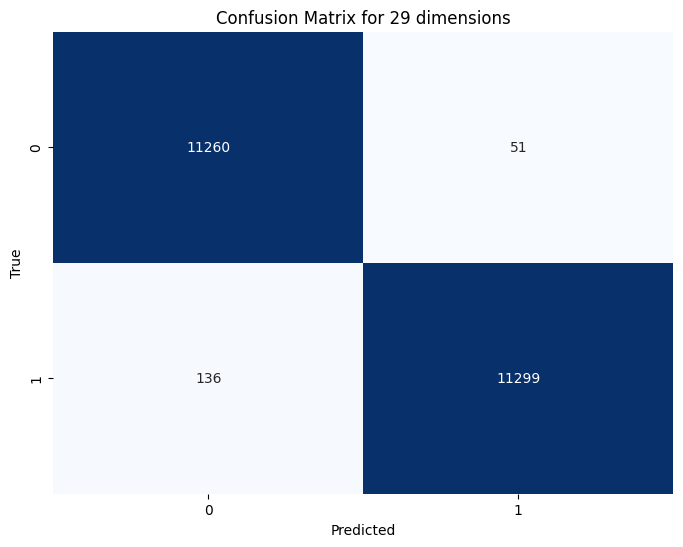

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Separate features and labels
X = data.iloc[:, :-1].values  #last column is the target variable
y = data.iloc[:, -1].values

# Normalizing the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)

# Creating DataLoader instances
batch_size = 64
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder definition for 29 features
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X_train.shape[1], 16),
            nn.PReLU(16),
            nn.BatchNorm1d(16),
            nn.Linear(16, 29),  # Updated to 29 features
            nn.PReLU(29),
            nn.BatchNorm1d(29)
        )
        self.decoder = nn.Sequential(
            nn.Linear(29, 16),
            nn.PReLU(16),
            nn.BatchNorm1d(16),
            nn.Linear(16, X_train.shape[1])
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Setting device
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# Creating the model and moving it to the device
autoencoder = Autoencoder().to(device)

# Defining optimizer
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=0.005)

# Training the autoencoder
num_epochs = 10

for epoch in range(num_epochs):
    for batch_data, in train_loader:
        batch_data = batch_data.to(device)

        autoencoder.zero_grad()
        reconstructions = autoencoder(batch_data)
        loss = nn.functional.mse_loss(reconstructions, batch_data)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

# Extracting encoded features from the test set
encoded_features_29 = []
with torch.no_grad():
    for batch_data, in test_loader:
        batch_data = batch_data.to(device)
        encoded_batch = autoencoder.encoder(batch_data)
        encoded_features_29.append(encoded_batch.cpu().numpy())

# Concatenating the encoded features
encoded_features_29 = np.concatenate(encoded_features_29, axis=0)

# Print the shape of the encoded features
print("Shape of Encoded Features (29):", encoded_features_29.shape)

# Split the encoded features into training and testing sets for classification
X_classify_train_29, X_classify_test_29, y_classify_train_29, y_classify_test_29 = train_test_split(
    encoded_features_29, y_test, test_size=0.2, random_state=42
)

# Convert encoded features and labels to PyTorch tensor
X_classify_train_tensor_29 = torch.Tensor(X_classify_train_29)
y_classify_train_tensor_29 = torch.Tensor(y_classify_train_29).long()

# Create DataLoader instance for the encoded features and labels
classify_train_dataset_29 = TensorDataset(X_classify_train_tensor_29, y_classify_train_tensor_29)
classify_train_loader_29 = DataLoader(classify_train_dataset_29, batch_size=batch_size, shuffle=True)

#`batch_data` is a batch of input data
with torch.no_grad():
    autoencoder.eval()
    reconstructions_29 = autoencoder(batch_data.to(device))
    mse_loss_29 = nn.functional.mse_loss(reconstructions_29, batch_data.to(device))
    print(f"Reconstruction Error (MSE) for the batch (29 features): {mse_loss_29.item():.4f}")

# Define the RNN classifier for 29 features
class RNNClassifier(nn.Module):
    def __init__(self, input_size, rnn_hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=rnn_hidden_size, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # using last output of the sequence
        return out

# Parameters for RNN classifier for 29 features
rnn_hidden_size_classify_29 = 64
num_classes_classify_29 = 2  #binary classification

# Creating the RNN classifier model  and moving to the device for 29 features
rnn_model_classify_29 = RNNClassifier(
    input_size=29, rnn_hidden_size=rnn_hidden_size_classify_29, num_classes=num_classes_classify_29
).to(device)

# Defining the optimizer and criterion for classification for 29 features
optimizer_classify_29 = torch.optim.Adam(params=rnn_model_classify_29.parameters(), lr=0.001)
criterion_classify_29 = nn.CrossEntropyLoss()

# Training the RNN classifier for 29 features
num_epochs_classify_29 = 10

for epoch in range(num_epochs_classify_29):
    for batch_data_classify, batch_labels_classify in classify_train_loader_29:
        optimizer_classify_29.zero_grad()
        outputs_classify_29 = rnn_model_classify_29(batch_data_classify.unsqueeze(1))  #unsqueeze for sequence dimension
        loss_classify_29 = criterion_classify_29(outputs_classify_29, batch_labels_classify.long())
        loss_classify_29.backward()
        optimizer_classify_29.step()

    print(f'Epoch {epoch + 1}/{num_epochs_classify_29}, Loss: {loss_classify_29.item():.4f}')

# Evaluate the RNN classifier on the test set
X_classify_test_tensor_29 = torch.Tensor(X_classify_test_29)
y_classify_test_tensor_29 = torch.Tensor(y_classify_test_29).long()

with torch.no_grad():
    rnn_model_classify_29.eval()
    outputs_test_classify_29 = rnn_model_classify_29(X_classify_test_tensor_29.unsqueeze(1))
    predictions_classify_29 = torch.argmax(F.softmax(outputs_test_classify_29, dim=1), dim=1)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_classify_test_29, predictions_classify_29.cpu().numpy()))

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_29 = confusion_matrix(y_classify_test_29, predictions_classify_29.cpu().numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_29, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for 29 dimensions")
plt.show()


# **ALL Features with SoftMax Classifier**

Shape of Encoded Features (29): (113726, 29)
Softmax Classifier - Epoch 1/10, Loss: 0.1663
Softmax Classifier - Epoch 2/10, Loss: 0.1064
Softmax Classifier - Epoch 3/10, Loss: 0.0902
Softmax Classifier - Epoch 4/10, Loss: 0.0644
Softmax Classifier - Epoch 5/10, Loss: 0.0436
Softmax Classifier - Epoch 6/10, Loss: 0.0348
Softmax Classifier - Epoch 7/10, Loss: 0.0544
Softmax Classifier - Epoch 8/10, Loss: 0.0252
Softmax Classifier - Epoch 9/10, Loss: 0.0757
Softmax Classifier - Epoch 10/10, Loss: 0.0132
Classification Report (29 dimensions):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11311
           1       0.98      0.98      0.98     11435

    accuracy                           0.98     22746
   macro avg       0.98      0.98      0.98     22746
weighted avg       0.98      0.98      0.98     22746



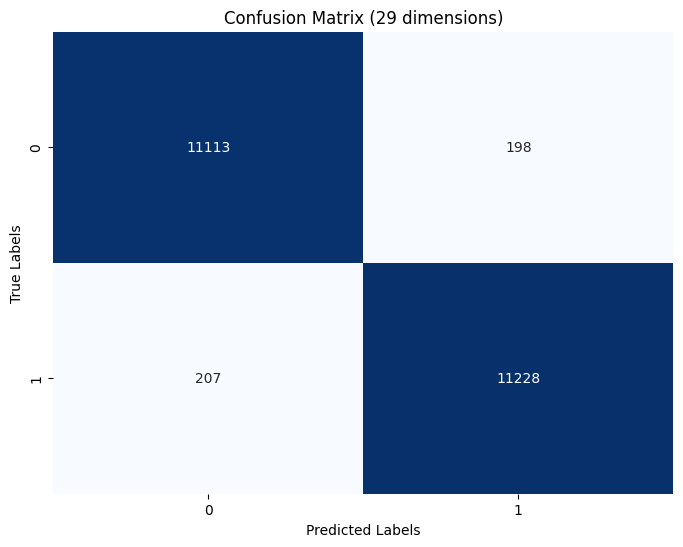

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# sofmax classifier with 29 dimensions
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# Printing the shape of the encoded features
print("Shape of Encoded Features (29):", encoded_features_29.shape)

# Defining the number of features after encoding for 29 dimensions
encoded_dim_29 = encoded_features_29.shape[1]

# Setting up the softmax classifier model for 29 dimensions
num_classes_softmax_29 = 2  #binary classification
softmax_model_29 = SoftmaxClassifier(input_size=encoded_dim_29, num_classes=num_classes_softmax_29).to(device)

# Defining loss function and optimizer for 29 dimensions
criterion_softmax_29 = nn.CrossEntropyLoss()
optimizer_softmax_29 = torch.optim.Adam(params=softmax_model_29.parameters(), lr=0.001)

# Training the softmax classifier for 29 dimensions
num_epochs_softmax_29 = 10

for epoch in range(num_epochs_softmax_29):
    for batch_data_softmax_29, batch_labels_softmax_29 in classify_train_loader_29:
        batch_data_softmax_29, batch_labels_softmax_29 = batch_data_softmax_29.to(device), batch_labels_softmax_29.to(device)

        optimizer_softmax_29.zero_grad()
        outputs_softmax_29 = softmax_model_29(batch_data_softmax_29)
        loss_softmax_29 = criterion_softmax_29(outputs_softmax_29, batch_labels_softmax_29.long())
        loss_softmax_29.backward()
        optimizer_softmax_29.step()

    print(f'Softmax Classifier - Epoch {epoch + 1}/{num_epochs_softmax_29}, Loss: {loss_softmax_29.item():.4f}')

# Evaluate the softmax classifier on the test set for 29 dimensions
softmax_model_29.eval()
with torch.no_grad():
    test_data_tensor_29 = torch.Tensor(X_classify_test_29).to(device)
    predicted_labels_29 = softmax_model_29(test_data_tensor_29)
    predicted_labels_29 = torch.argmax(predicted_labels_29, dim=1).cpu().numpy()

# Print the classification report for 29 dimensions
print("Classification Report (29 dimensions):")
print(classification_report(y_classify_test_29, predicted_labels_29))

# Plot the confusion matrix for 29 dimensions
cm_29sm = confusion_matrix(y_classify_test_29, predicted_labels_29)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_29sm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (29 dimensions)')
plt.show()


# **Comparing ALL RNN CLASSIFIERS with DIFFERENT NO. OF FEATURES**

### Classification Report - 5 Features

[[10956   355]
 [  740 10695]]


### Classification Report - 10 Features

[[11181   130]
 [  240 11195]]


### Classification Report - 20 Features

[[11224    87]
 [  105 11330]]


### Classification Report - 29 Features

[[11260    51]
 [  136 11299]]


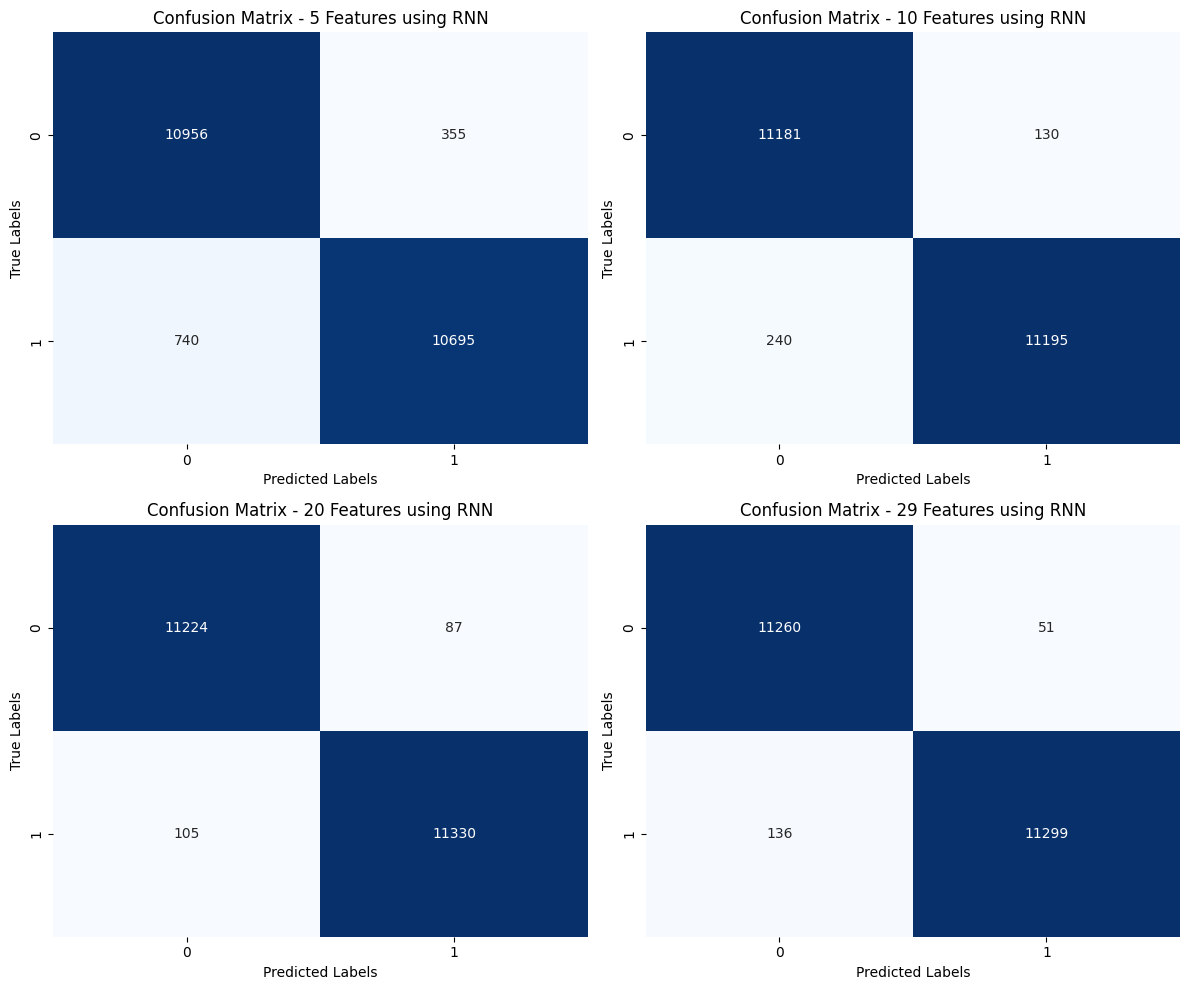

In [ ]:
from IPython.display import display, Markdown
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

classification_report_5 = cm
classification_report_10 = cm_10
classification_report_20 = cm_20rnn
classification_report_29 = cm_29

# Create subplots with 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Displaying the classification reports using Markdown
display(Markdown("### Classification Report - 5 Features"))
print(classification_report_5)

# Confusion matrix for 5 features
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 0])
axes[0, 0].set_xlabel('Predicted Labels')
axes[0, 0].set_ylabel('True Labels')
axes[0, 0].set_title('Confusion Matrix - 5 Features using RNN')

display(Markdown("### Classification Report - 10 Features"))
print(classification_report_10)

# Confusion matrix for 10 features
sns.heatmap(cm_10, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 1])
axes[0, 1].set_xlabel('Predicted Labels')
axes[0, 1].set_ylabel('True Labels')
axes[0, 1].set_title('Confusion Matrix - 10 Features using RNN')

display(Markdown("### Classification Report - 20 Features"))
print(classification_report_20)

# Confusion matrix for 20 features
sns.heatmap(cm_20rnn, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted Labels')
axes[1, 0].set_ylabel('True Labels')
axes[1, 0].set_title('Confusion Matrix - 20 Features using RNN')

display(Markdown("### Classification Report - 29 Features"))
print(classification_report_29)

# Confusion matrix for 29 features
sns.heatmap(cm_29, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted Labels')
axes[1, 1].set_ylabel('True Labels')
axes[1, 1].set_title('Confusion Matrix - 29 Features using RNN')

# Adjust layout
plt.tight_layout()
plt.show()


# **Comparing ALL SOFTMAX CLASSIFIERS with DIFFERENT NO. OF FEATURES**

### Classification Report - 5 Features

[[10944   367]
 [  730 10705]]


### Classification Report - 10 Features

[[11129   182]
 [  488 10947]]


### Classification Report - 20 Features

[[11160   151]
 [  253 11182]]


### Classification Report - 29 Features

[[11113   198]
 [  207 11228]]


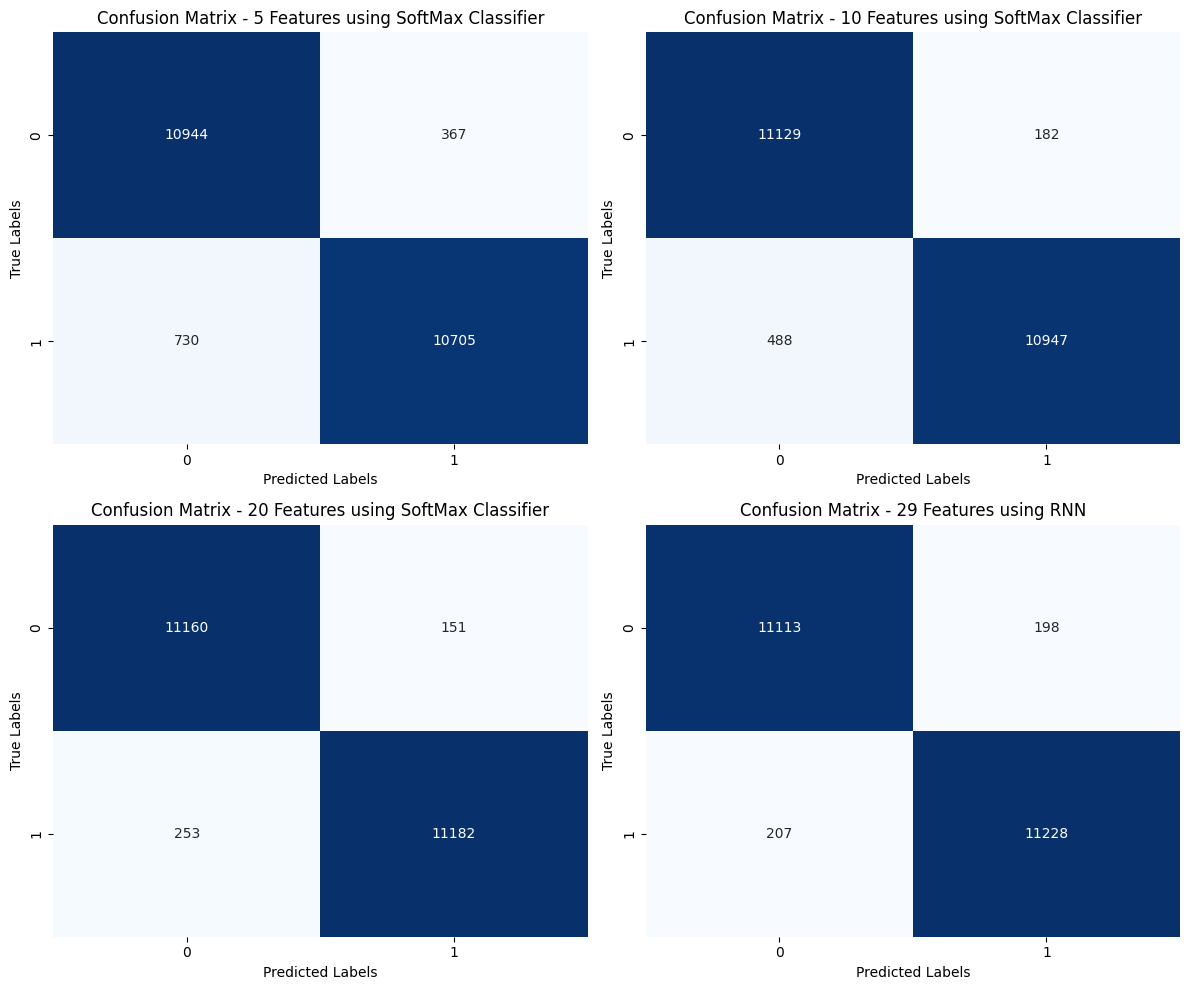

In [ ]:
from IPython.display import display, Markdown
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

classification_report_5 = cm_5_sm
classification_report_10 = cm_10sm
classification_report_20 = cm_20
classification_report_29 = cm_29sm

# Create subplots with 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Displaying the classification reports using Markdown
display(Markdown("### Classification Report - 5 Features"))
print(classification_report_5)

# Confusion matrix for 5 features
sns.heatmap(cm_5_sm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 0])
axes[0, 0].set_xlabel('Predicted Labels')
axes[0, 0].set_ylabel('True Labels')
axes[0, 0].set_title('Confusion Matrix - 5 Features using SoftMax Classifier')

display(Markdown("### Classification Report - 10 Features"))
print(classification_report_10)

# Confusion matrix for 10 features
sns.heatmap(cm_10sm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 1])
axes[0, 1].set_xlabel('Predicted Labels')
axes[0, 1].set_ylabel('True Labels')
axes[0, 1].set_title('Confusion Matrix - 10 Features using SoftMax Classifier')

display(Markdown("### Classification Report - 20 Features"))
print(classification_report_20)

# Confusion matrix for 20 features
sns.heatmap(cm_20, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted Labels')
axes[1, 0].set_ylabel('True Labels')
axes[1, 0].set_title('Confusion Matrix - 20 Features using SoftMax Classifier')

display(Markdown("### Classification Report - 29 Features"))
print(classification_report_29)

# Confusion matrix for 29 features
sns.heatmap(cm_29sm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted Labels')
axes[1, 1].set_ylabel('True Labels')
axes[1, 1].set_title('Confusion Matrix - 29 Features using SoftMax Classifier')

# Adjust layout
plt.tight_layout()
plt.show()
